In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import pdb
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS

# Notebook with simple experiments

## Task 1

### Receiving of the true $\theta$ and generating of a dataset

In [2]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"

z_dim = 2 # Latent space dimensionality
data_dim = 10 # Data dimensionality
N = 10000 # Dataset size

sigma_0 = 1. # True std

In [3]:
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device),
                                                scale=torch.tensor(1., device=device))
std_normal_pyro = torch.distributions.Normal(loc=torch.tensor(0., device=device),
                                                scale=torch.tensor(1., device=device))
true_theta = std_normal.sample((z_dim, data_dim)) * sigma_0
print('True decoder matrix')
print(true_theta)
print('-' * 100)

data_probs = torch.sigmoid(std_normal.sample((N, z_dim)) @ true_theta)
data = torch.distributions.Bernoulli(probs=data_probs).sample()

print('Generated data example:')
print(data[:10])

True decoder matrix
tensor([[ 1.5480, -0.3517,  1.1872,  1.0751, -0.2913,  1.2378,  2.6538,  1.2332,
         -0.2694, -1.9401],
        [-0.0521,  0.1061, -0.8929, -1.3056,  0.7165, -0.8852, -1.5876, -0.6525,
         -0.4251, -0.2089]], device='cuda:1')
----------------------------------------------------------------------------------------------------
Generated data example:
tensor([[0., 0., 0., 1., 0., 1., 0., 1., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [0., 1., 0., 1., 1., 0., 1., 1., 1., 1.],
        [1., 0., 1., 1., 0., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 1.],
        [0., 1., 1., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 1., 1., 1., 1., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 1., 1.],
        [1., 0., 1., 1., 0., 0., 1., 0., 0., 0.]], device='cuda:1')


## Task 2

### Sample z with target $p(z|x)$, using HMC (NUTS)

#### 1) Bernoulli likelihood from torch

In [4]:
n_warmup = 20000
n_samples = 1000

data_ind = 0  #  index of datapoint we conditioned on

In [5]:
def potential_fn(z):
    z = z['points']
    probs = torch.sigmoid(z @ true_theta)
    return -torch.sum(pyro.distributions.Bernoulli(probs=probs).log_prob(data[data_ind]).sum(1) + std_normal_pyro.log_prob(z).sum(1))

In [6]:
init_samples = std_normal_pyro.sample((1, z_dim))
init_params = {'points': init_samples}

nuts_kernel = NUTS(potential_fn=potential_fn)
mcmc = MCMC(nuts_kernel,
            initial_params=init_params,
            num_samples=n_samples,
            warmup_steps=n_warmup)

mcmc.run()
z = mcmc.get_samples()['points'].squeeze()

Sample: 100%|██████████| 21000/21000 [02:01, 173.08it/s, step size=6.59e-01, acc. prob=0.948]


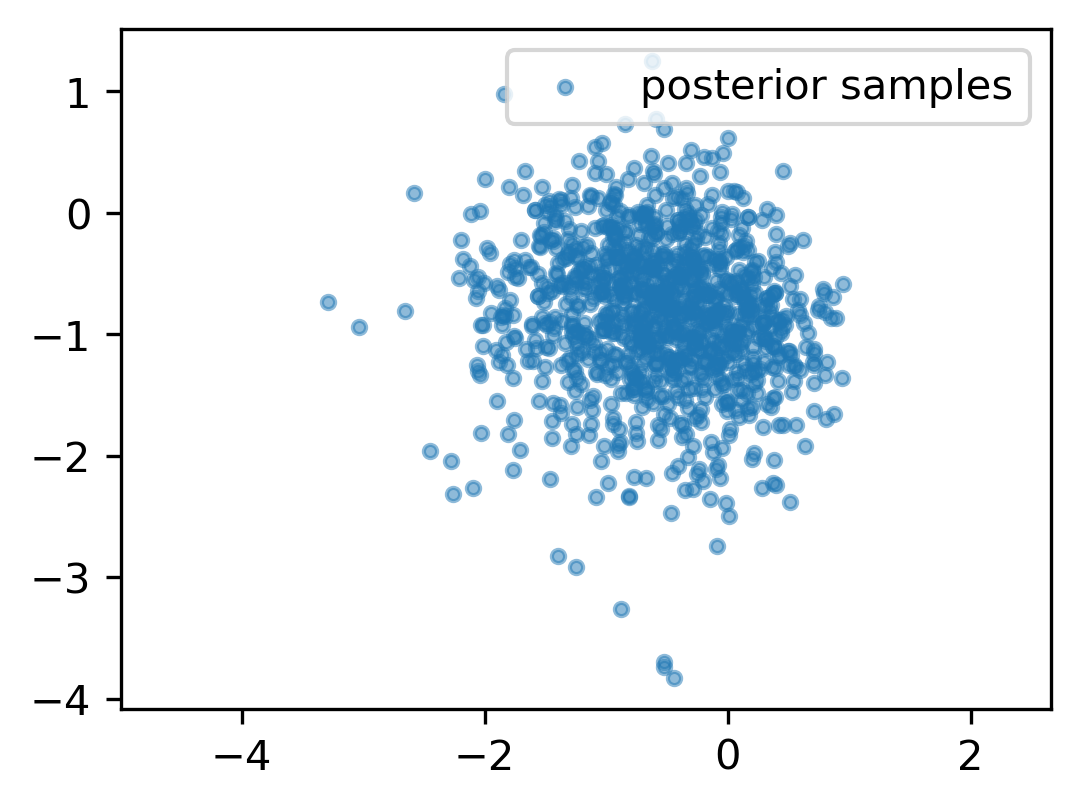

In [7]:
plt.figure(figsize=(4, 3), dpi=300)
plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), label='posterior samples', s=10, alpha=0.5)
plt.legend()
plt.axis('equal');

#### 2) Using simplified likelihood

In [8]:
def potential_fn(z):
    z = z['points']
#     pdb.set_trace()
    prod = z @ true_theta
    potential = -data[data_ind] * prod + torch.log(1. + torch.exp(prod))
    return potential.sum()

In [9]:
init_samples = std_normal_pyro.sample((1, z_dim))
init_params = {'points': init_samples}

nuts_kernel = NUTS(potential_fn=potential_fn)
mcmc = MCMC(nuts_kernel,
            initial_params=init_params,
            num_samples=n_samples,
            warmup_steps=n_warmup)

mcmc.run()
z = mcmc.get_samples()['points'].squeeze()

Sample: 100%|██████████| 21000/21000 [01:40, 208.72it/s, step size=5.39e-01, acc. prob=0.948]


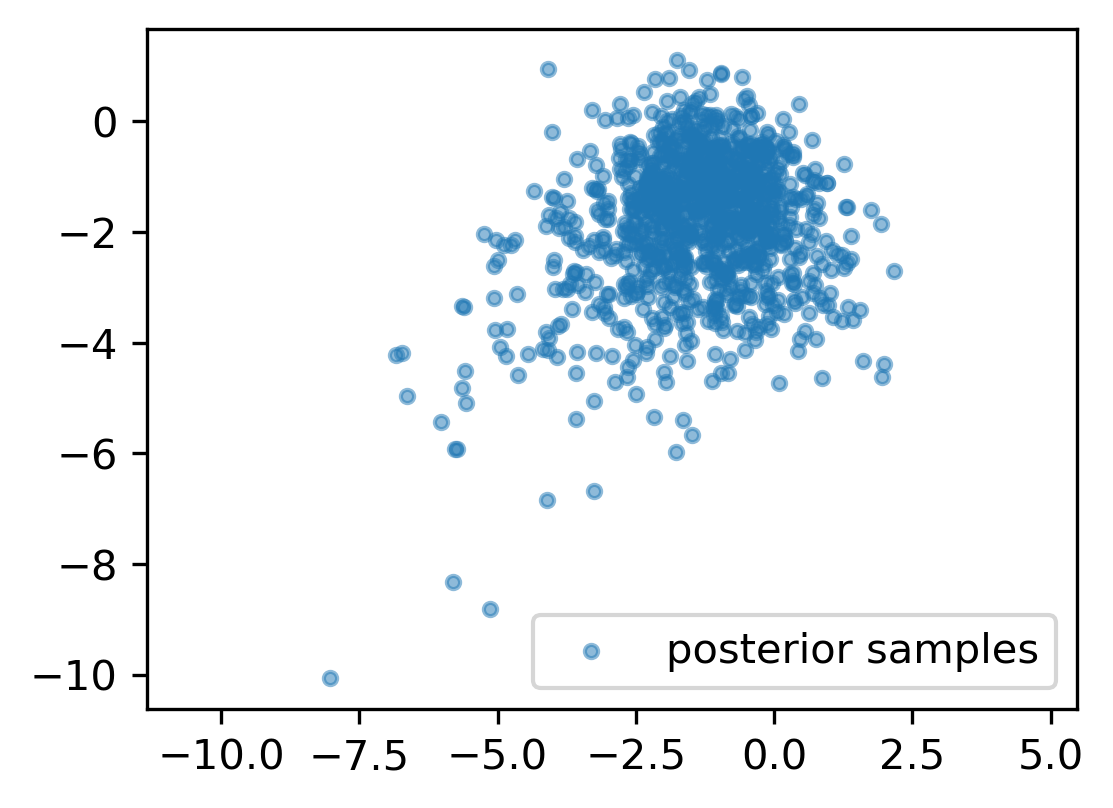

In [10]:
plt.figure(figsize=(4, 3), dpi=300)
plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), label='posterior samples', s=10, alpha=0.5)
plt.legend()
plt.axis('equal');

## Task 3

#### Fisher's identity

In [11]:
class Decoder(nn.Module):
    def __init__(self, data_dim, z_dim):
        super(Decoder, self).__init__()
        self.W = nn.Linear(in_features=z_dim, out_features=data_dim, bias=False)
    def forward(self, z):
        return self.W(z)

In [12]:
num_epoches = 10
batch_size = 1
n_samples = 10
n_warmup = 50

print_info_ = 1

In [4]:
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

NameError: name 'batch_size' is not defined

In [14]:
dec = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(params=dec.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max')

In [15]:
def potential_fn(z):
    z = z['points']
    probs = torch.sigmoid(z @ current_matrix)
    return -torch.sum(pyro.distributions.Bernoulli(probs=probs).log_prob(batch_train).sum(1) + std_normal_pyro.log_prob(z).sum(1))

In [16]:
for ep in tqdm(range(num_epoches)): # cycle over epoches
    plt.close()
    j = 0
    obj_sum = 0
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
        
        init_samples = std_normal.sample((batch_train.shape[0], z_dim))
        init_params = {'points': init_samples}
        
        current_matrix = dec.W.weight.detach().T
        
        nuts_kernel = NUTS(potential_fn=potential_fn)
        mcmc = MCMC(nuts_kernel,
                    initial_params=init_params,
                    num_samples=n_samples,
                    warmup_steps=n_warmup,
                   disable_progbar=True)
        mcmc.run()
        z = mcmc.get_samples()['points'][-n_samples:]
        
#         pdb.set_trace()
        
        probs = torch.sigmoid(dec(z))
        obj = torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).mean(0).sum(1).mean()

        (-obj).backward()
        optimizer.step()
        optimizer.zero_grad()
        
        j += 1
        obj_sum += obj.cpu().detach().numpy()
#     scheduler.step(obj)
    if ep % print_info_ == 0:
        print('obj:', obj.cpu().detach().item())

 10%|█         | 1/10 [08:36<1:17:31, 516.88s/it]

obj: -6.918155670166016


 20%|██        | 2/10 [17:06<1:08:38, 514.83s/it]

obj: -7.071194648742676


 30%|███       | 3/10 [25:43<1:00:06, 515.26s/it]

obj: -5.697913646697998


 40%|████      | 4/10 [34:20<51:34, 515.78s/it]  

obj: -5.683789253234863


 50%|█████     | 5/10 [42:58<43:02, 516.43s/it]

obj: -5.650333881378174


 60%|██████    | 6/10 [51:35<34:26, 516.65s/it]

obj: -7.33448600769043


 70%|███████   | 7/10 [1:00:19<25:56, 518.86s/it]

obj: -4.999856948852539


 80%|████████  | 8/10 [1:09:02<17:20, 520.08s/it]

obj: -4.772363662719727


 90%|█████████ | 9/10 [1:17:49<08:42, 522.38s/it]

obj: -4.8393964767456055


100%|██████████| 10/10 [1:26:34<00:00, 519.41s/it]

obj: -6.8601837158203125


In [17]:
print('true_theta', true_theta)
print('-' * 100)
print(dec.W.weight.detach().T)

true_theta tensor([[-0.2034, -0.8231, -0.7005,  1.9532, -0.9161,  0.4564,  0.3238,  0.5572,
         -1.1345, -1.3714],
        [ 0.4382, -2.4232, -0.9977,  1.0264,  0.2021, -0.0529, -0.3315,  0.8314,
          1.7450, -1.3644]], device='cuda:1')
----------------------------------------------------------------------------------------------------
tensor([[-0.0488,  0.9389,  0.9162, -1.0752,  0.1523, -0.3990,  0.2387, -0.5239,
         -0.4191,  1.2328],
        [ 0.0724,  0.3645, -0.2113, -0.0586, -0.4942,  0.3028,  0.2749, -0.4141,
         -0.7001, -0.1912]], device='cuda:1')


## Task 4

### Simple VAE

In [4]:
class Encoder_vae(nn.Module):
    def __init__(self, data_dim, z_dim, K):
        super(Encoder_vae, self).__init__()
        self.h1 = nn.Linear(in_features=data_dim, out_features=K)
        self.h2 = nn.Linear(in_features=K, out_features=K)
        self.mu = nn.Linear(in_features=K, out_features=z_dim)
        self.sigma = nn.Linear(in_features=K, out_features=z_dim)
    def forward(self, x):
        h1 = F.selu(self.h1(x))
        h2 = F.selu(self.h2(h1))
        return self.mu(h2), F.softplus(self.sigma(h2))
    
class Decoder(nn.Module):
    def __init__(self, data_dim, z_dim):
        super(Decoder, self).__init__()
        self.W = nn.Linear(in_features=z_dim, out_features=data_dim, bias=False)
    def forward(self, z):
        return self.W(z)

In [5]:
K = 16
num_epoches = 5000
batch_size = 200
print_info_ = 500

dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

enc = Encoder_vae(data_dim=data_dim, z_dim=z_dim, K=K).to(device)
dec = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)

params = list(enc.parameters()) + list(dec.parameters())
optimizer = torch.optim.Adam(params=params, lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max', patience=50, factor=0.75)

In [ ]:
for ep in tqdm(range(num_epoches)): # cycle over epoches
    plt.close()
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
#         pdb.set_trace()
        mu, sigma = enc(batch_train) # sample mu and sigma from encoder
        u = std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + u * sigma # reperametrization trick

        prod = dec(z)
        log_likelihood = torch.mean(torch.distributions.Bernoulli(probs=torch.sigmoid(prod)).log_prob(batch_train))

        KLD = -0.5 * torch.mean(1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2))
#             KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        elbo = log_likelihood - KLD
        (-elbo).backward()

        optimizer.step()
        optimizer.zero_grad()
    scheduler.step(elbo)
    if ep % print_info_ == 0:
#             pdb.set_trace()
        print('elbo:', elbo.cpu().detach().numpy())
        print('likelihood', log_likelihood.cpu().detach().numpy())
        print('KLD', KLD.cpu().detach().numpy())

  0%|          | 2/5000 [00:00<13:17,  6.27it/s]

elbo: -0.90983725
likelihood -0.70384693
KLD 0.20599033


 10%|█         | 502/5000 [01:10<10:39,  7.03it/s]

elbo: -0.6931698
likelihood -0.69316906
KLD 7.266551e-07


 20%|██        | 1002/5000 [02:21<09:30,  7.01it/s]

elbo: -0.693257
likelihood -0.6932559
KLD 1.0854005e-06


 30%|███       | 1502/5000 [03:32<08:13,  7.08it/s]

elbo: -0.69312537
likelihood -0.6931247
KLD 6.8373976e-07


 40%|████      | 2002/5000 [04:42<07:01,  7.11it/s]

elbo: -0.69319165
likelihood -0.6931902
KLD 1.4352053e-06


 50%|█████     | 2502/5000 [05:52<05:52,  7.08it/s]

elbo: -0.6931166
likelihood -0.6931162
KLD 3.9875508e-07


 60%|██████    | 3002/5000 [07:02<04:38,  7.16it/s]

elbo: -0.6929578
likelihood -0.69295645
KLD 1.3584644e-06


 70%|███████   | 3502/5000 [08:12<03:29,  7.16it/s]

elbo: -0.6931249
likelihood -0.6931243
KLD 5.7548283e-07


 77%|███████▋  | 3842/5000 [08:59<02:43,  7.07it/s]

In [ ]:
print('true_theta', true_theta)
print('-' * 100)
print(dec.W.weight.detach().T)